
##This notebook intends to analyze and create a model on the Blood Donation  dataset to predict whether or not a donor will give blood the next time.


[Try the web app](https://ibrahim-projets.herokuapp.com/projets/blood/)

In [ ]:
from google.colab import drive
 
drive.mount('/gdrive')
# the project's folder
%cd /gdrive/'My Drive'/projets

Mounted at /gdrive
/gdrive/My Drive/projets


In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import gc
import matplotlib.pyplot as plt
import time 
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df_train=pd.read_csv('/gdrive/My Drive/projets/blood_train.csv')
df_train.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


In [ ]:
df_train.shape

(576, 6)

In [ ]:
#rename id et made donation
df_train.columns = ['id','Months_since_Last_Donation','Number_donations','Total_Volume_Donated','Months_since_First_Donation', 'Target']
print(df_train.isnull().sum())
df_train = df_train.drop('id',axis = 1 )
df_train.head()

id                             0
Months_since_Last_Donation     0
Number_donations               0
Total_Volume_Donated           0
Months_since_First_Donation    0
Target                         0
dtype: int64


,Months_since_Last_Donation,Number_donations,Total_Volume_Donated,Months_since_First_Donation,Target
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff52c95f9e8>,
      dtype=object)

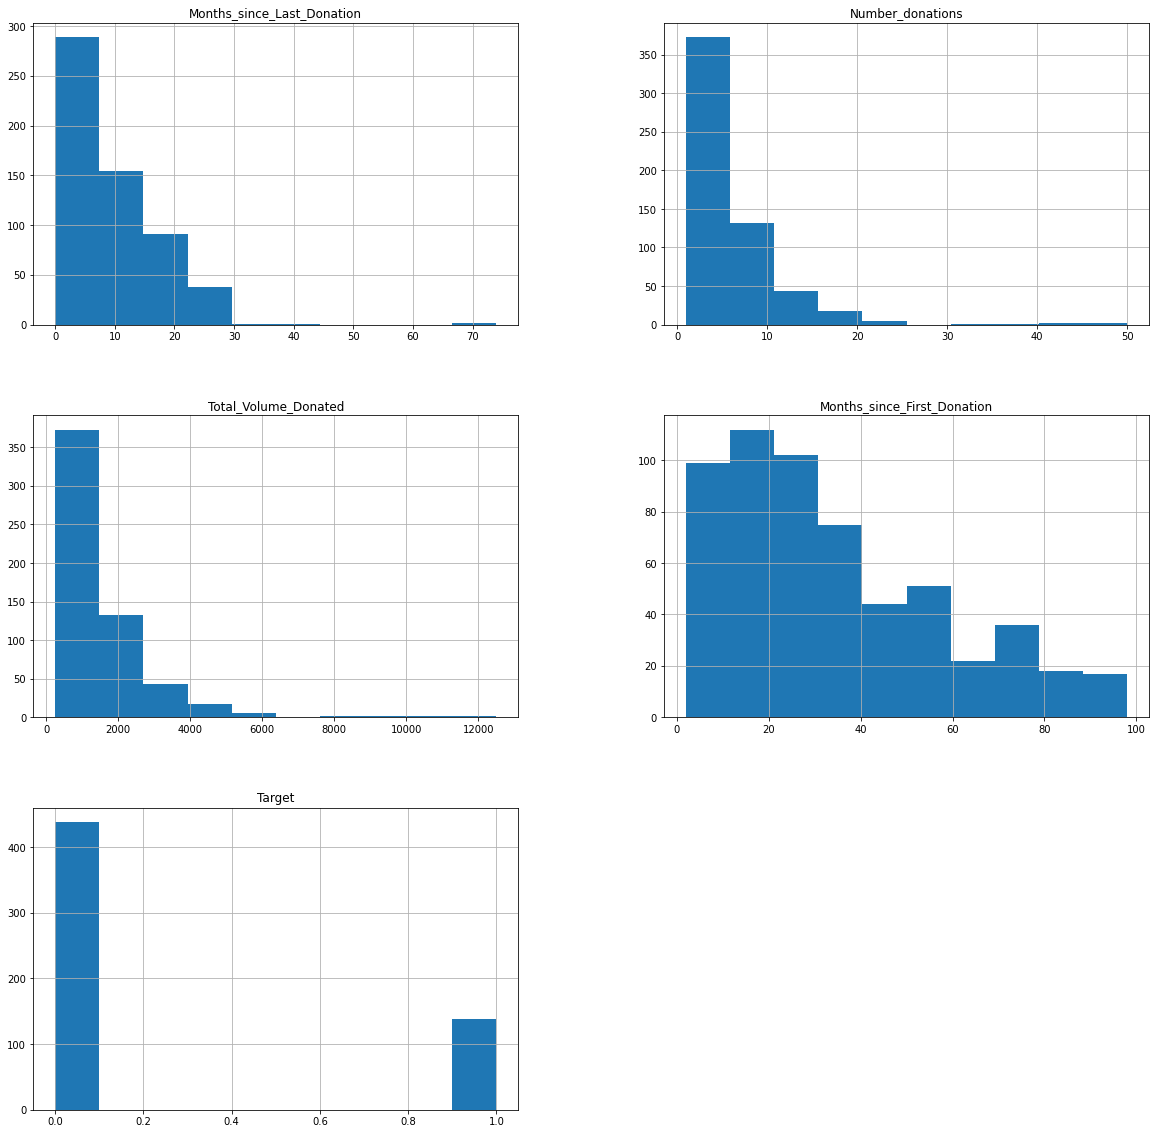

In [ ]:
df_train.hist(figsize = (20,20))

In [ ]:
df_train.describe(include='all')

,Months_since_Last_Donation,Number_donations,Total_Volume_Donated,Months_since_First_Donation,Target
count,576.000000,576.000000,576.000000,576.000000,576.000000
mean,9.439236,5.427083,1356.770833,34.050347,0.239583
std,8.175454,5.740010,1435.002556,24.227672,0.427200
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.000000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,49.250000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


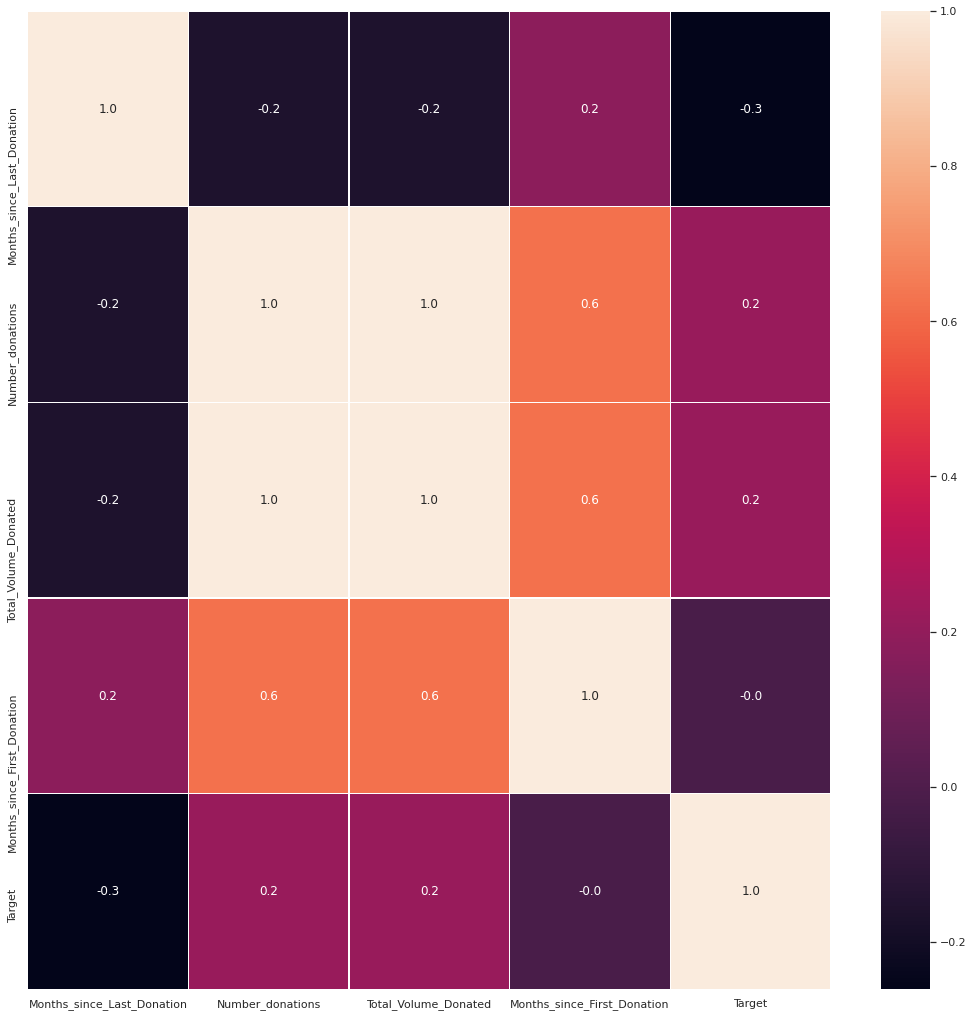

In [ ]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

<center>
Only months_since_first_donation seems to have a significative correlation with the class probability.</center>

In [ ]:
target= df_train.Target                       
feature_to_remove = ['Target']
df = df_train.drop(feature_to_remove,axis = 1 )
df.head()

,Months_since_Last_Donation,Number_donations,Total_Volume_Donated,Months_since_First_Donation
0,2,50,12500,98
1,0,13,3250,28
2,1,16,4000,35
3,2,20,5000,45
4,1,24,6000,77


##Visualization
<p>Before violin and swarm plot visualization we need to normalize or standardize.</p>

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

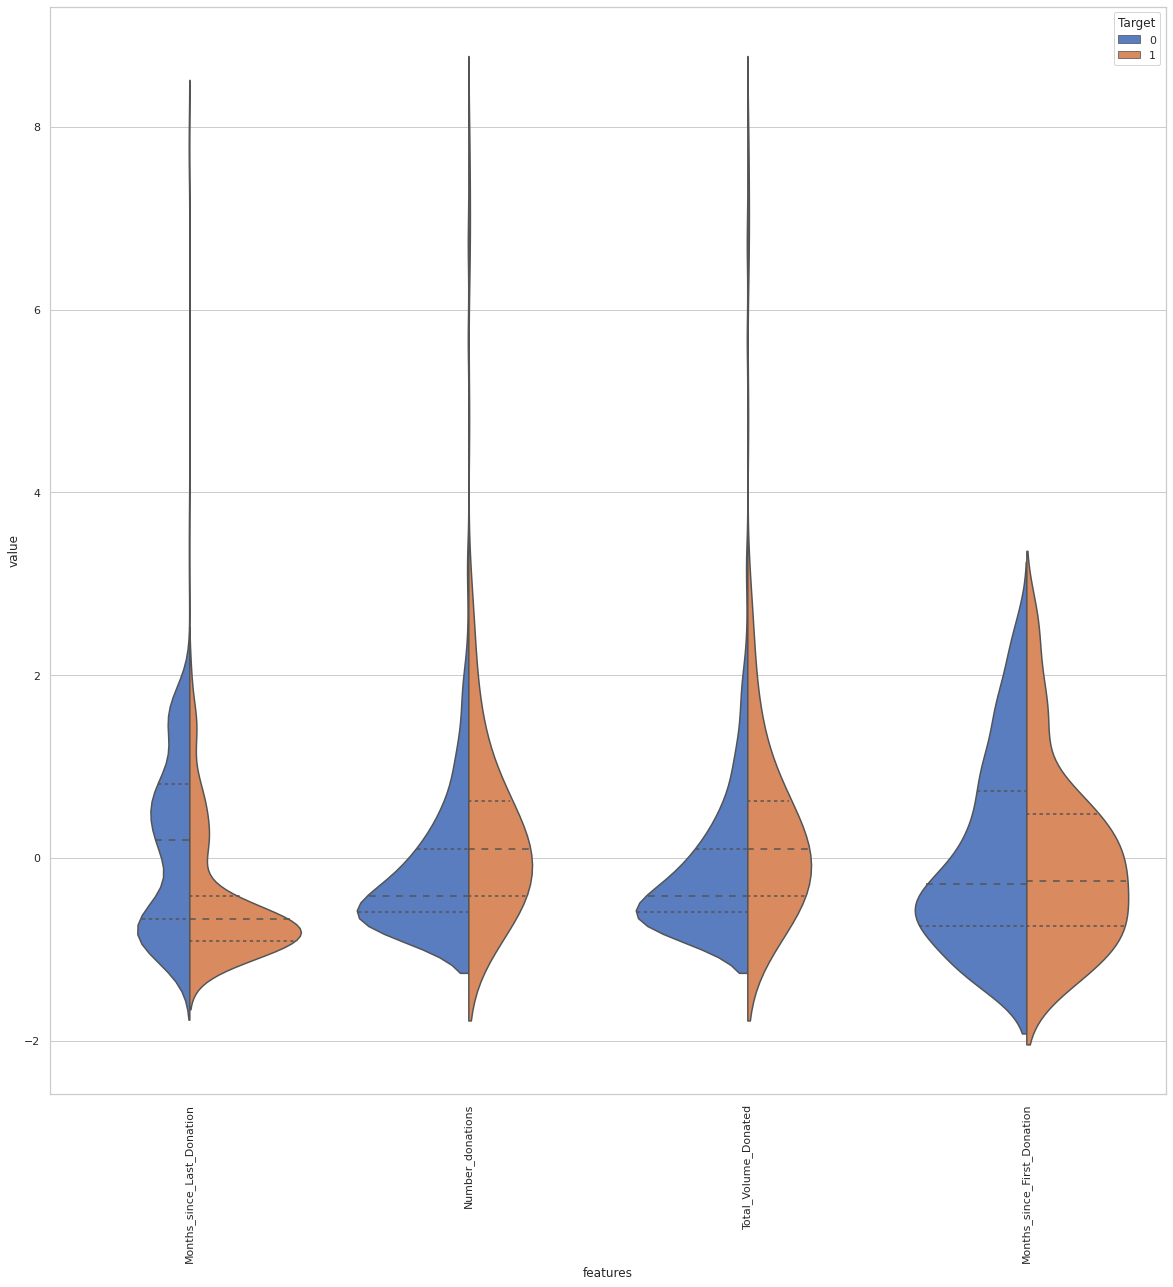

In [ ]:
data = (df- df.mean()) / (df.std())              # standardization
data = pd.concat([target,data],axis=1)
data = pd.melt(data,id_vars="Target",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(20,20))
sns.violinplot(x="features", y="value", hue="Target", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

<p>
Only months_since_first_donation seems to be a good differentiator. Number donations and Total Volume Donated are high correlated each other  I will remove one.</p>

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 36.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 27.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

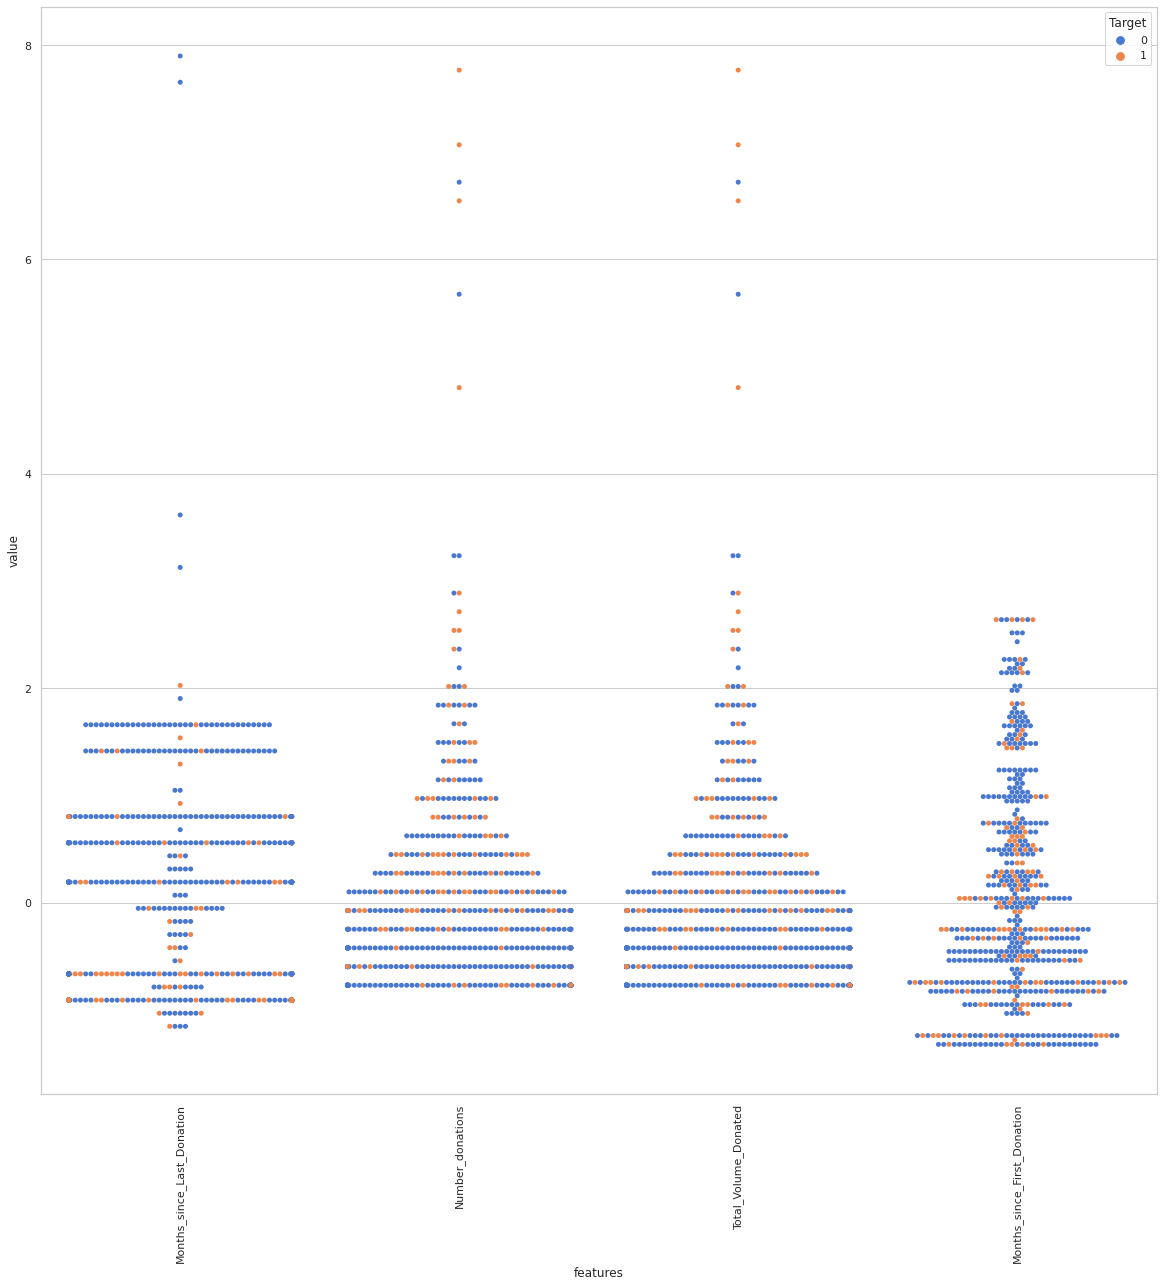

In [ ]:
sns.set(style="whitegrid", palette="muted")
data = (df- df.mean()) / (df.std())       
data = pd.concat([target,data],axis=1)
data = pd.melt(data,id_vars="Target",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(20,20))
sns.swarmplot(x="features", y="value", hue="Target", data=data)
#sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

In [ ]:
df

,Months_since_Last_Donation,Number_donations,Total_Volume_Donated,Months_since_First_Donation
0,2,50,12500,98
1,0,13,3250,28
2,1,16,4000,35
3,2,20,5000,45
4,1,24,6000,77
...,...,...,...,...
571,23,1,250,23
572,16,3,750,86
573,21,2,500,52
574,39,1,250,39


<p>I drop Total Volume donated</p>

In [ ]:
df = df.drop('Total_Volume_Donated',axis = 1 )

In [ ]:
df

,Months_since_Last_Donation,Number_donations,Months_since_First_Donation
0,2,50,98
1,0,13,28
2,1,16,35
3,2,20,45
4,1,24,77
...,...,...,...
571,23,1,23
572,16,3,86
573,21,2,52
574,39,1,39


In [ ]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(df,target , test_size=0.3, random_state=42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

     Months_since_Last_Donation  Number_donations  Months_since_First_Donation
349                          21                 1                           21
271                          11                 2                           21
149                          13                 8                           26
124                           2                 1                            2
433                           2                 9                           75
..                          ...               ...                          ...
71                            2                 6                           28
106                           4                 5                           28
270                          11                 5                           50
435                           4                 9                           55
102                           2                 5                           34

[403 rows x 3 columns]


In [ ]:
from pickle import dump
dump(sc, open('blood.pkl', 'wb'))


In [ ]:
X_train

array([[ 1.43804861, -0.75773735, -0.52835188],
       [ 0.1787405 , -0.58742606, -0.52835188],
       [ 0.43060212,  0.43444172, -0.31935521],
       ...,
       [ 0.1787405 , -0.07649217,  0.68382881],
       [-0.70277517,  0.60475301,  0.89282548],
       [-0.95463679, -0.07649217,  0.01503946]])

In [ ]:
# Build neural network with Keras
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=3))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=150, verbose=False)

# Results - Accuracy
scores = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: %.2f%%\n" % (scores[1]*100))
scores = model.evaluate(X_test, y_test, verbose=True)
print("Testing Accuracy: %.2f%%\n" % (scores[1]*100))

13/13 [==============================] - 0s 1ms/step - loss: 0.4263 - accuracy: 0.8114
Training Accuracy: 81.14%

6/6 [==============================] - 0s 1ms/step - loss: 0.4949 - accuracy: 0.7861
Testing Accuracy: 78.61%



In [ ]:
model.save('pred_blood.hdf5')

###Gradient Boosting

In [ ]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(df,target , test_size=0.3, random_state=42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# Gradient boosting tunning

gradient_boost = GradientBoostingClassifier()
grid_param = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
grid_GBC = GridSearchCV(gradient_boost,param_grid = grid_param, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

grid_GBC.fit(X_train,y_train)

GBC_best_model = grid_GBC.best_estimator_

# Best score
grid_GBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   34.3s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   54.0s finished


0.7966463414634146

In [ ]:
joblib.dump(GBC_best_model, 'blood_donation_with_gbm.pkl')

['blood_donation_with_gbm.pkl']

In [ ]:
#load your model for further usage
model=joblib.load("blood_donation_with_gbm.pkl")

In [ ]:
gsGBC.best_params_

{'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 4,
 'max_features': 0.3,
 'min_samples_leaf': 100,
 'n_estimators': 100}

[Try the web app](https://ibrahim-projets.herokuapp.com/projets/blood/)